# Reproducing EBV quantification from 1kGP

Caleb Lareau
2025 Aug 11

### About
Here we provide an overview of the key steps to extract EBV DNA from existing WGS crams using the 1000 Genomes Project (1kGP) as an exemplar. This dataset is slightly different from biobanks (e.g., AoU or UKB) because 1) these are immortalized LCLs with very high EBV DNA copy numbers; and 2) this is openly accessible data consented for public analysis - hence we can provide all the details. 


### In terminal: 

In Terra, if you look to your right, you will see a terminal window. We recommend running these commands in the command line environment for simplicity:

```
cd 1000G-high-coverage-2019\ copy/edit/ # update based on what you call your workspace; this is the default

wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.fa

wget https://1000genomes.s3.amazonaws.com/technical/reference/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.fa.fai

wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.dict

wget https://github.com/broadinstitute/gatk/releases/download/4.2.6.0/gatk-4.2.6.0.zip

unzip gatk-4.2.6.0

mkdir ebv_bams

```

### Stage crams
As part of the "Data" table in your Terra workspace (in the GUI), there is a "sample" table:

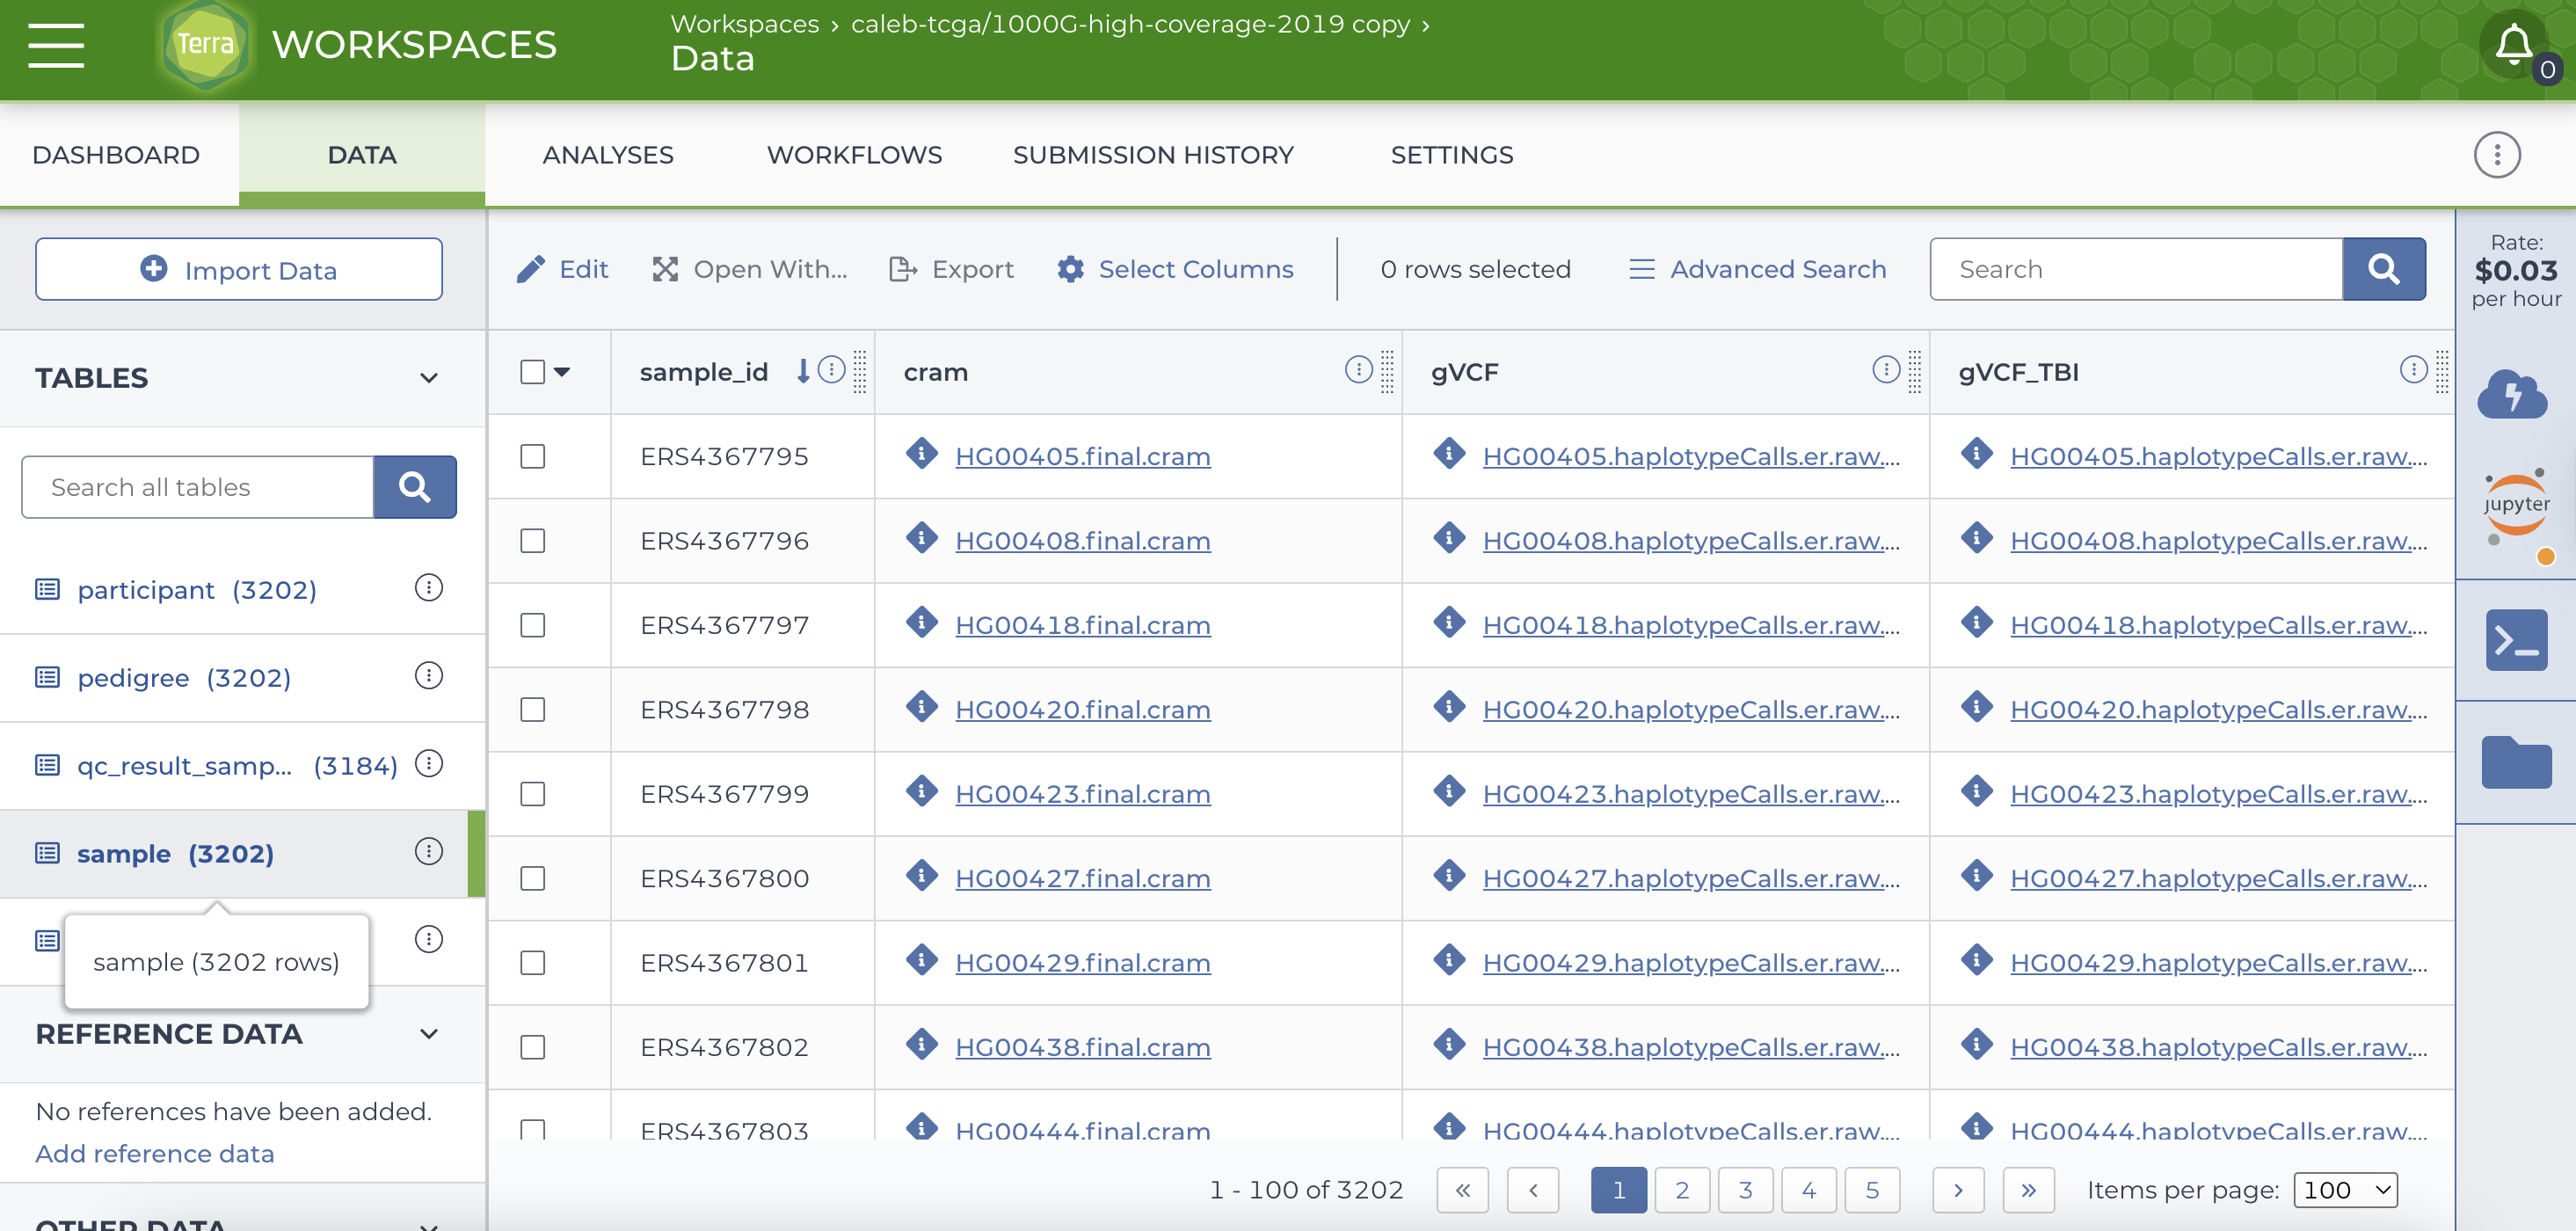

In [2]:
# install.packages("IRdisplay")
library(IRdisplay)
display_png(file = "1kGP_terra.png")

We download that locally and then upload `.cram` files to a file called `cram_list.txt`. An example of what this file should look like (just one `.cram` per line) is shown below. 

### Verify setup
If you have everything that you need for downloading, you should see this (note first file is the name of this `.ipynb`). 

In [46]:
list.files(".")

[1] "01_1000G_EBV.ipynb"                            
[2] "cram_list.tsv"                                 
[3] "ebv_bams"                                      
[4] "gatk-4.2.6.0"                                  
[5] "gatk-4.2.6.0.zip"                              
[6] "GRCh38_full_analysis_set_plus_decoy_hla.dict"  
[7] "GRCh38_full_analysis_set_plus_decoy_hla.fa"    
[8] "GRCh38_full_analysis_set_plus_decoy_hla.fa.fai"

## R code for analyses

In [27]:
# Install package dependencies for later
install.packages(c("BiocManager", "dplyr", "ggplot2", "data.table"))
BiocManager::install(c("Rsamtools", "GenomicRanges", "BiocParallel", "GenomicAlignments"))

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.0 (2025-04-11)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'Rsamtools' 'GenomicRanges' 'GenomicAlignments'”
Installing package(s) 'BiocParallel'

Old packages: 'alabaster.base', 'AnnotationHub', 'AnVIL', 'BiocFileCache',
  'BiocManager', 'BiocParallel', 'broom', 'cli', 'commonmark', 'cowplot',
  'curl', 'data.table', 'DelayedArray', 'DESeq2', 'diffobj', 'edgeR',
  'evaluate', 'ExperimentHub', 'fitdistrplus', 'future', 'future.apply',
  'generics', 'GenomeInfoDb', 'gh', 'globals', 'h5mread', 'haven', 'httr2',
  'KEGGREST', 'limma', 'openssl', 'parallelly', 'patchwork', 'pbapply',
  'pillar', 'pkgbuild', 'pkgdown', 'plotly', 'promises', 'purrr', 'Rcpp',
  'R

In [33]:
# Load packages
library(dplyr)
library(ggplot2)
library(BiocParallel)
library(GenomicAlignments)
library(data.table)


Attaching package: ‘data.table’


The following objects are masked from ‘package:GenomicAlignments’:

    first, last, second


The following object is masked from ‘package:SummarizedExperiment’:

    shift


The following object is masked from ‘package:GenomicRanges’:

    shift


The following object is masked from ‘package:IRanges’:

    shift


The following objects are masked from ‘package:S4Vectors’:

    first, second


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [14]:
# Import Google project
google_project <- system("echo $GOOGLE_PROJECT", intern=TRUE)
google_project

[1] "terra-68cd0db9"

In [19]:
# Read in the crams that you want to process associated with this workspace
# This file is a simple 1 cram per line
cram_df <- read.table("cram_list.tsv", header = FALSE)
head(cram_df)

,V1
,<chr>
1,gs://fc-56ac46ea-efc4-4683-b6d5-6d95bed41c5e/CCDG_14151/Project_CCDG_14151_B01_GRM_WGS.cram.2020-02-12/Sample_HG00405/analysis/HG00405.final.cram
2,gs://fc-56ac46ea-efc4-4683-b6d5-6d95bed41c5e/CCDG_14151/Project_CCDG_14151_B01_GRM_WGS.cram.2020-02-12/Sample_HG00408/analysis/HG00408.final.cram
3,gs://fc-56ac46ea-efc4-4683-b6d5-6d95bed41c5e/CCDG_14151/Project_CCDG_14151_B01_GRM_WGS.cram.2020-02-12/Sample_HG00418/analysis/HG00418.final.cram
4,gs://fc-56ac46ea-efc4-4683-b6d5-6d95bed41c5e/CCDG_14151/Project_CCDG_14151_B01_GRM_WGS.cram.2020-02-12/Sample_HG00420/analysis/HG00420.final.cram
5,gs://fc-56ac46ea-efc4-4683-b6d5-6d95bed41c5e/CCDG_14151/Project_CCDG_14151_B01_GRM_WGS.cram.2020-02-12/Sample_HG00423/analysis/HG00423.final.cram
6,gs://fc-56ac46ea-efc4-4683-b6d5-6d95bed41c5e/CCDG_14151/Project_CCDG_14151_B01_GRM_WGS.cram.2020-02-12/Sample_HG00427/analysis/HG00427.final.cram


In [21]:
# Extract them into a vector; we're taking the first 30 for the sake of efficient run time
need_crams <- head(cram_df[[1]],30)

In [31]:
# constant sequences we need for each download
string_one <- "./gatk-4.2.6.0/gatk PrintReads -I "
string_two <- " -L chrEBV -R GRCh38_full_analysis_set_plus_decoy_hla.fa -O ebv_bams/"
string_three <- ".ebv.bam --gcs-project-for-requester-pays "
string_four <- " --cloud-prefetch-buffer 0 --cloud-index-prefetch-buffer 0"

# Loop over all crams and download
bplapply(need_crams,  BPPARAM = MulticoreParam(16), function(one_cram){
    basename <- gsub(".final.cram", "", basename(one_cram))
    cmd <- paste0(string_one, one_cram, string_two, basename, string_three, google_project, string_four)
    system(cmd)
    basename
})


[[1]]
[1] "HG00405"

[[2]]
[1] "HG00408"

[[3]]
[1] "HG00418"

[[4]]
[1] "HG00420"

[[5]]
[1] "HG00423"

[[6]]
[1] "HG00427"

[[7]]
[1] "HG00429"

[[8]]
[1] "HG00438"

[[9]]
[1] "HG00444"

[[10]]
[1] "HG00447"

[[11]]
[1] "HG00450"

[[12]]
[1] "HG00453"

[[13]]
[1] "HG00459"

[[14]]
[1] "HG00465"

[[15]]
[1] "HG00474"

[[16]]
[1] "HG00477"

[[17]]
[1] "HG00480"

[[18]]
[1] "HG00501"

[[19]]
[1] "HG00502"

[[20]]
[1] "HG00512"

[[21]]
[1] "HG00514"

[[22]]
[1] "HG00526"

[[23]]
[1] "HG00532"

[[24]]
[1] "HG00535"

[[25]]
[1] "HG00538"

[[26]]
[1] "HG00544"

[[27]]
[1] "HG00552"

[[28]]
[1] "HG00555"

[[29]]
[1] "HG00558"

[[30]]
[1] "HG00561"

In [29]:
# Verify downloads
head(list.files("ebv_bams"))

[1] "HG00405.ebv.bai" "HG00405.ebv.bam" "HG00408.ebv.bai" "HG00408.ebv.bam"
[5] "HG00418.ebv.bai" "HG00418.ebv.bam"

In [35]:
# Now make per person, per-position abundance
# We have a 16 core machine so we will parallelize over 16 cores
all_ebv_cov_df <- bplapply(need_crams,  BPPARAM = MulticoreParam(16), function(one_cram){
    basename <- gsub(".final.cram", "", basename(one_cram))
    ga_in <- readGAlignments(paste0("ebv_bams/", basename, ".ebv.bam"), param = ScanBamParam(what="mapq"))
    ga_in <- ga_in[ga_in@elementMetadata$mapq >= 30]
    cov_df <- data.frame(val = (ga_in %>% coverage)[["chrEBV"]]) %>%
      mutate(idx = 1:n(), donor = basename)
    cov_df
}) %>% rbindlist() %>% data.frame()

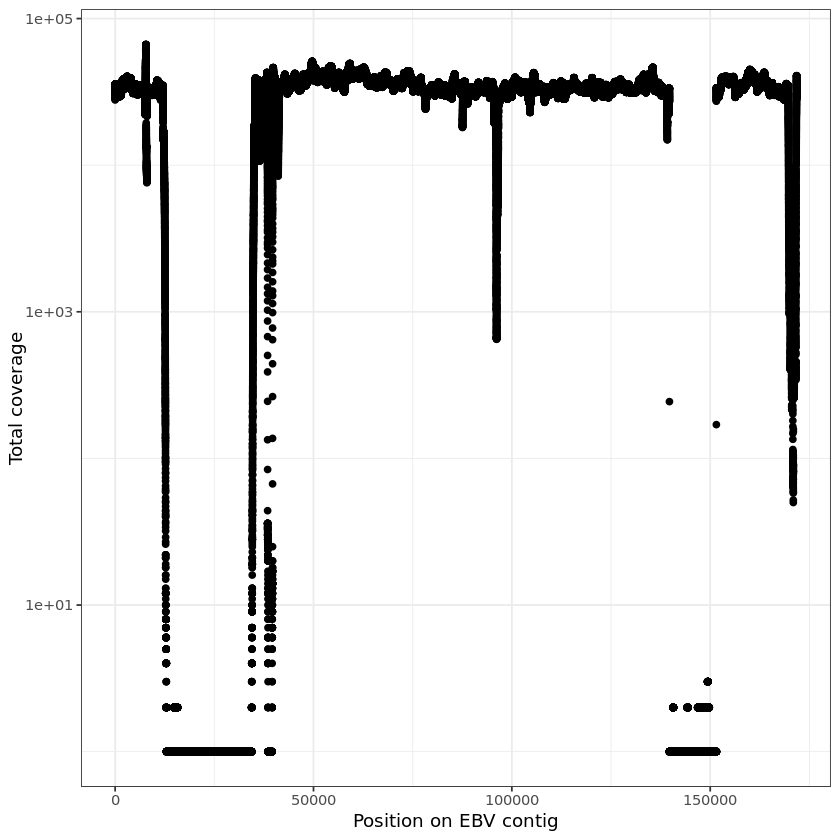

In [38]:
# First make a plot of the coverage across the contig
# Note the characteristic dips in the coverage as we described due to low mappability
per_position_df <- all_ebv_cov_df %>% 
    group_by(idx) %>% summarize(total_cov = sum(val))

ggplot(per_position_df, aes(x = idx, y = total_cov + 1)) + 
    geom_point() + scale_y_log10() + theme_bw() + labs(x = "Position on EBV contig", y = "Total coverage")

Note that we don’t see the regions with abnormally high coverage (as we described in the paper) - likely because in this case, there is a lot more EBV DNA that drowns out the non-specific signal from the human genome. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


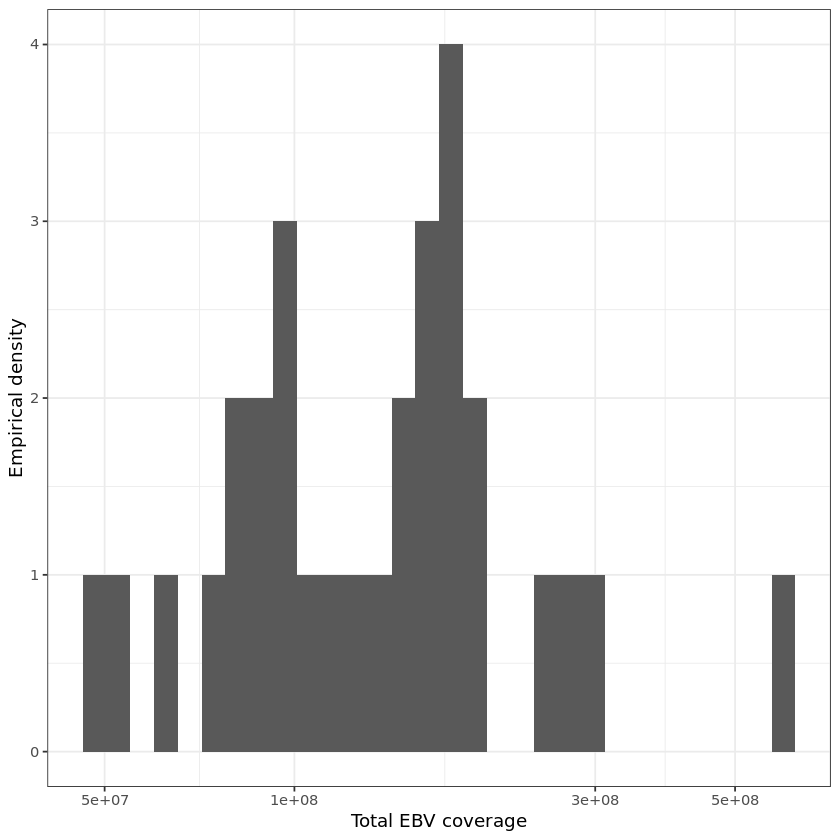

In [43]:
# Now tally the abundance per person
# Note: this is higher than peripheral blood
per_donor_df <- all_ebv_cov_df %>% 
    group_by(donor) %>% summarize(total_ebv_coverage = sum(val))

ggplot(per_donor_df, aes(x = total_ebv_coverage)) + 
    geom_histogram() + theme_bw() + labs(x = "Total EBV coverage", y = "Empirical density") + scale_x_log10()

In [45]:
# Finally examine the per-donor abundance
head(per_donor_df)

donor,total_ebv_coverage
<chr>,<int>
HG00405,84764207
HG00408,136529064
HG00418,163478209
HG00420,124310508
HG00423,194396557
HG00427,63215418


Now that you have a data table that tabulates the total EBV coverage per person, this will allow you to threshold EBV DNA loads (or use them as continuous values) for all downstream association analyses! 